In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import proplot as pplt
from scipy.fftpack import * 
import metpy

## 2D DCT get 1D spectrum
按照Denis 2002的方法进行2D dct的谱合并，制作1D谱分析

## 2021.07.26 renew

修正了DCTN的方法，用正交的方法，检查平均值和0，0位置的谱；具体见denis 2002对于谱方差的计算，以及修改后绘制的振幅（对方差开方）

添加ERA5I的动能谱

## 2021.08.13 renew

添加简单的计算经纬度网格上的测地线距离的方法

## 2021.10.18 renew

在同目录的 interp_rcmgrid.ipynb 的处理之后，得到新的投影网格下的模式结果，进行谱分析



## 数据读入

2021.08.23

修改为在高度上进行积分的动能Ke

In [2]:
in_path = {}
case_number = "case4"
filename = "ke_all_8.5-11.5_km_vi_LambertConformal_" + case_number + ".nc"
in_path['vr'] = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/ke_daily_vi_proj/" + filename # VR
in_path['rcm'] = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/ke_daily_vi_proj/" + filename # RCM
in_path['era5i'] = "/raid52/yycheng/MPAS/REFERENCE/ERA5I_NC/ERA5I_NC_daily/ke_daily_vi_proj/" + filename # ERA5I

ke_sum = {}
for imod in ['vr', 'rcm', 'era5i']:
    ke_sum[imod] = xr.open_dataset(in_path[imod])['ke']

In [3]:
# 选取数据范围
sel_dict = {}
month_sel = [6,7,8]
year_sel  = np.arange(1998,2018)
# year_sel  = [2000,2001,2002,2003,2004,2005,2006]
# year_sel = [2002]

month_sel_cond  = ke_sum['vr'].Time.dt.month.isin(month_sel)
year_sel_cond   = ke_sum['vr'].Time.dt.year.isin(year_sel)

var_sel = {}
sel_dict['Time'] = month_sel_cond  & year_sel_cond
var_sel['vr']  = ke_sum['vr'].loc[sel_dict]
var_sel['rcm'] = ke_sum['rcm'].loc[sel_dict]
var_sel['era5i'] = ke_sum['era5i'].loc[sel_dict]

## DCTN

In [4]:
# 2D fft
# ke_vi_sum # Time x lat x lon : 3080 x 160 x 280
dctn_3d = {}
dctn_3d['vr'] = dctn(var_sel['vr'].values, type = 2, axes = [1,2], norm = 'ortho')
dctn_3d['rcm'] = dctn(var_sel['rcm'].values, type = 2, axes = [1,2], norm = 'ortho')
dctn_3d['era5i'] = dctn(var_sel['era5i'].values, type = 2, axes = [1,2], norm = 'ortho')

# 添加维度参数
ntime = dctn_3d['vr'].shape[0]
nlat  = dctn_3d['vr'].shape[1]
nlon  = dctn_3d['vr'].shape[2]
print(ntime)

1840


## DCTN CHECK

检查（0,0）位置的系数和区域平均场差异：做差结果: -5.684341886080802e-14


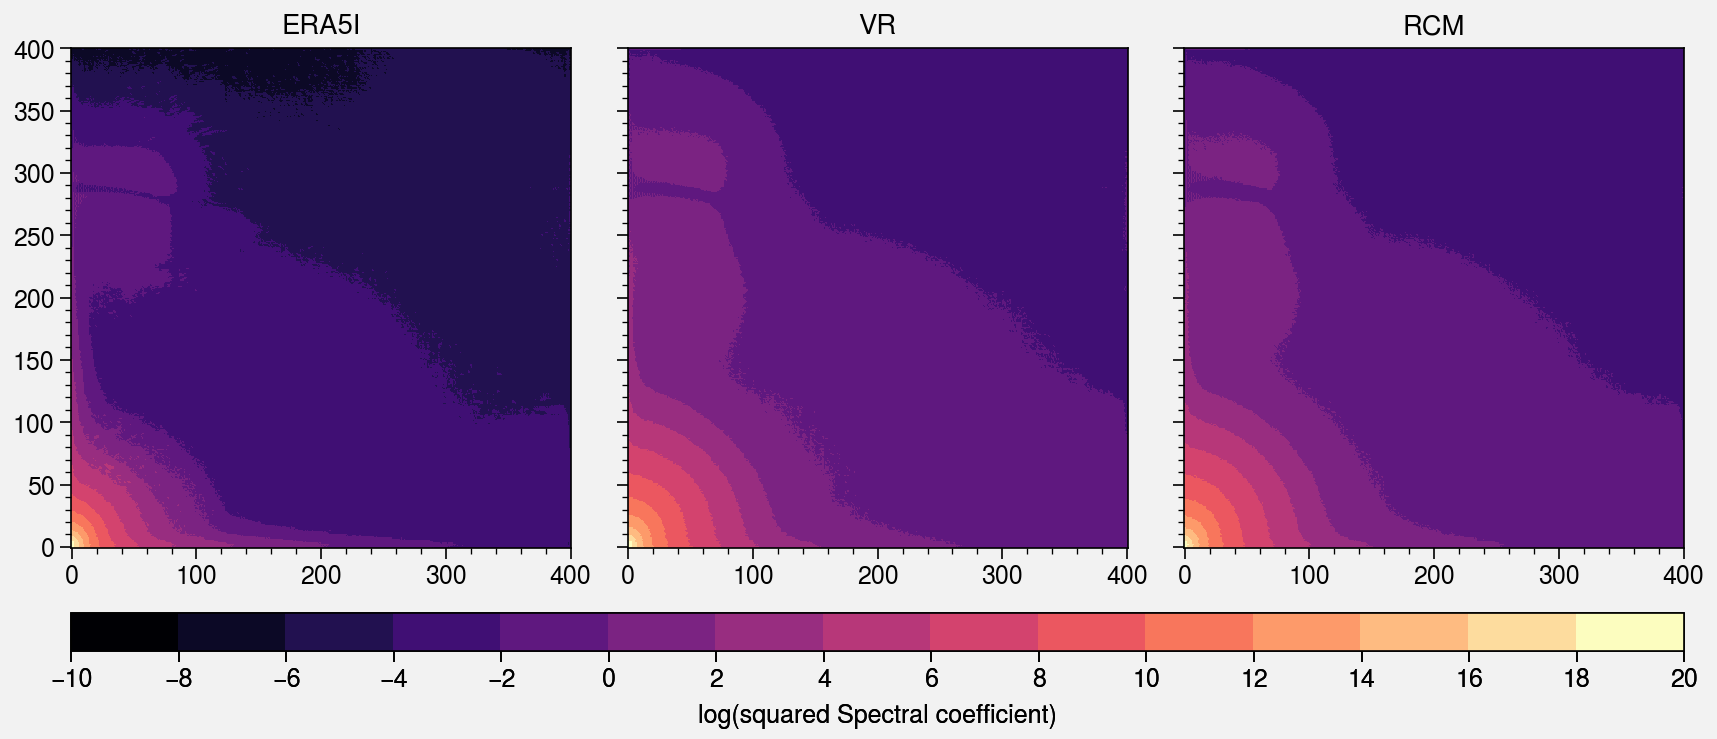

In [5]:
# 平均对应谱的0，0位置的系数检查
# domain_avg 应该和 spectrum_coef 保持一致，为此调整了 DCT 的 norm = 'ortho' 参数，让这个条件满足
domain_avg = var_sel['vr'][0,:,:].values.mean()
spectrum_coef = dctn_3d['vr'][0, 0, 0] / np.sqrt(nlat) / np.sqrt(nlon)
# domain_avg # 252.37
print("检查（0,0）位置的系数和区域平均场差异：做差结果: " + str(spectrum_coef  - domain_avg))

## 使用proplot做简单方差谱的绘制检查
import proplot as pplt
import numpy as np

# 计算方差谱的对数(2D)
# variance_era5i = np.log(np.abs(dctn_3d['era5i'].mean(axis=0)**2))
# variance_vr    = np.log(np.abs(dctn_3d['vr'].mean(axis=0)**2))
# variance_rcm    = np.log(np.abs(dctn_3d['rcm'].mean(axis=0)**2))

variance_era5i = np.log((np.abs(dctn_3d['era5i']**2).mean(axis=0)))
variance_vr    = np.log((np.abs(dctn_3d['vr']**2).mean(axis=0)))
variance_rcm    = np.log((np.abs(dctn_3d['rcm']**2).mean(axis=0)))

# 用proplot仔细画一下
# Figure
fig, axs = pplt.subplots(ncols=3, span=False)
axs.format(
    xlabel='', ylabel='', grid=True,
    suptitle=''
)

# Plot with colormaps and normalizers
cmap = 'magma'
levels =  pplt.arange(-10, 20, 2)
axs[0].pcolormesh(variance_era5i, cmap=cmap, levels = levels)
axs[1].pcolormesh(variance_vr, cmap=cmap, levels = levels)
pcolormesh = axs[2].pcolormesh(variance_rcm, cmap=cmap, levels = levels)
# axs[1].pcolormesh(np.abs(dctn_3d['era5i'][:,:].mean(axis=0)**2), norm='log', cmap=cmap, colorbar='b')

axs[0].format(title='ERA5I')
axs[1].format(title='VR')
axs[2].format(title='RCM')

axs.format(
# xlocator='log', xminorlocator='logminor',
)
fig.colorbar(pcolormesh, loc='b', label = "log(squared Spectral coefficient)")
# domaininfo_str = str(lat_s) + "~" + str(lat_e) + "N_" + str(lon_s) + "~" + str(lon_e) + "E"
# axs[0].format(suptitle = "domain size: " + domaininfo_str)
# plt.savefig('./output_pic/ke_variance_'+domaininfo_str+'.png', dpi=300, facecolor= "white")

## 从2D谱方位角求和获得1D谱

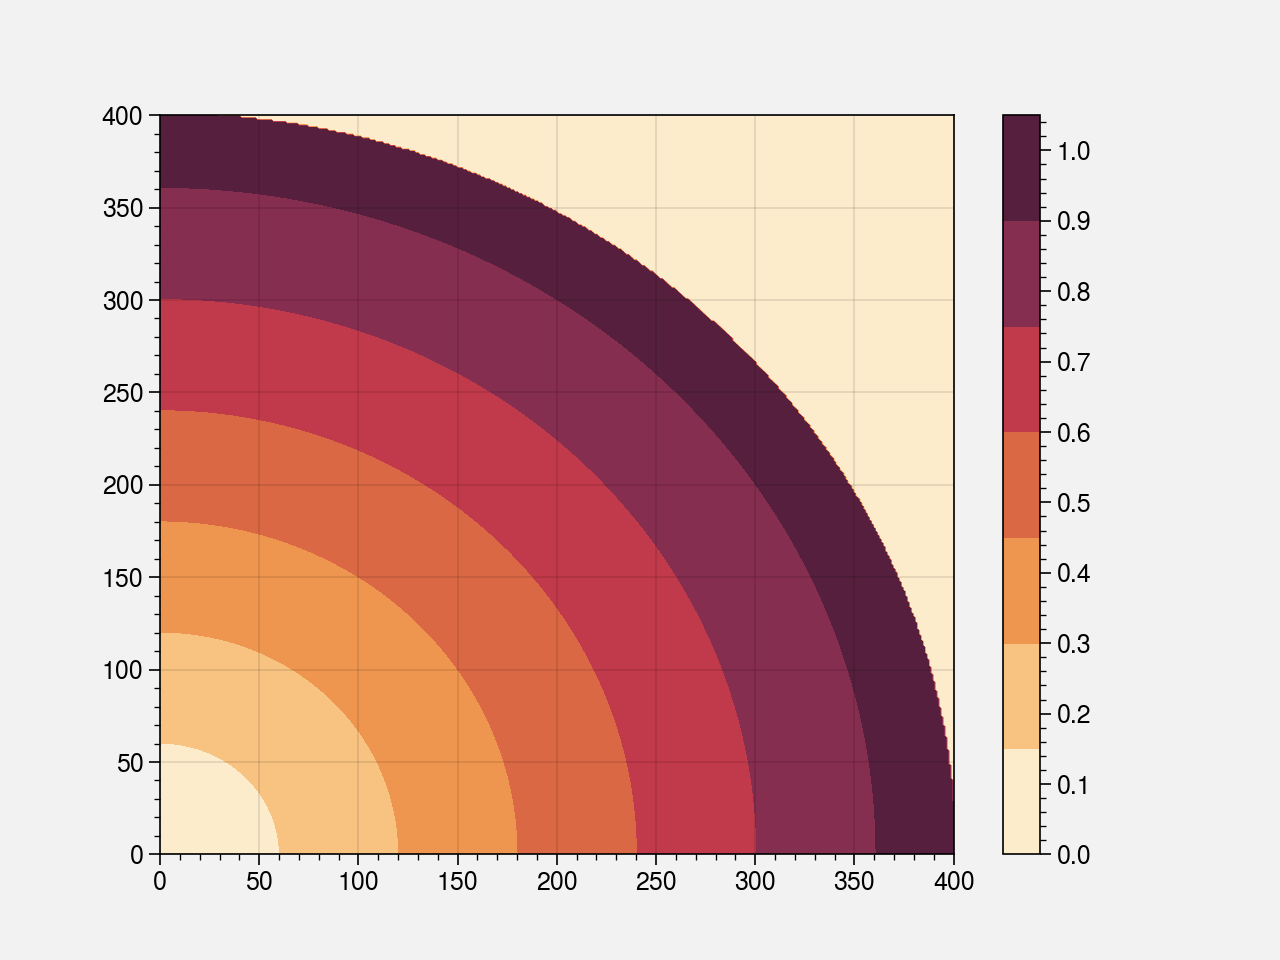

In [6]:
# 仿照denis2002进行2d alpha的预估
# nlat = 160 (miner)
# nlon = 280
Y, X     = np.ogrid[0:nlat, 0:nlon]
r        = np.hypot(X, Y).astype(np.int)
# 2D normalize wavenumber
alpha_2d =  np.empty(shape=r.shape)
for ilat in range(0,nlat):
    for ilon in range(0,nlon):
        alpha_2d[ilat, ilon] = np.sqrt( ilon**2/nlon**2 + ilat**2/nlat**2 )

alpha_1d = np.zeros(shape = int(np.min([nlat,nlon])))
for i in range(0, np.min([nlat, nlon]) ):
    alpha_1d[i] = i / np.min([nlat, nlon])
# 用于确定bins的1D谱
# alpha_1d = np.arange(1,nlat+1, 1) / nlat
# 去除掉alpha_2d中大于1的部分
alpha_2d = np.where(alpha_2d<=1, alpha_2d, 0)
plt.contourf(alpha_2d)
plt.colorbar(ticks = np.linspace(0,1,11))

- 旧算法 先计算平均谱再计算1D谱

In [7]:
N = np.min([nlat, nlon])

variance_1d = {}
variance_1d['vr'] =  np.zeros(shape=[nlat])
variance_1d['rcm'] =  np.zeros(shape=[nlat])
variance_1d['era5i'] =  np.zeros(shape=[nlat])

# 按照alpha进行bins，合并2d谱为1d谱，预先进行谱的时间平均

variance_2d = {} # 时间平均???如何平均，平均系数还是平均方差 是一个时次itime 的variance
#  先进行系数的平均，在计算variance
variance_2d['vr'] = (dctn_3d['vr']).mean(axis=0)**2 /nlat / nlon
variance_2d['rcm'] = (dctn_3d['rcm']).mean(axis=0)**2 /nlat / nlon
variance_2d['era5i'] = (dctn_3d['era5i']).mean(axis=0)**2 /nlat / nlon

# 先计算variance，再计算系数的平均
# variance_2d['vr'] = (dctn_3d['vr']**2/nlat /nlon).mean(axis=0) 
# variance_2d['rcm'] = (dctn_3d['rcm']**2/nlat /nlon).mean(axis=0) 
# variance_2d['era5i'] = (dctn_3d['era5i']**2/nlat /nlon).mean(axis=0) 


for i in range(0, np.min([nlat,nlon]) - 1):
    sel_index  = (alpha_2d >= alpha_1d[i]) & (alpha_2d < alpha_1d[i + 1])
    # mean or sum???
    # variance_1d['vr'][i] = variance_2d['vr'][sel_index].mean()
    # variance_1d['rcm'][i] = variance_2d['rcm'][sel_index].mean()
    # variance_1d['era5i'][i] = variance_2d['era5i'][sel_index].mean()
    # 方位角积分
    variance_1d['vr'][i] = variance_2d['vr'][sel_index].sum()
    variance_1d['rcm'][i] = variance_2d['rcm'][sel_index].sum()
    variance_1d['era5i'][i] = variance_2d['era5i'][sel_index].sum()


# 进行三点平滑
# variance_1d['vr']
variance_1d_filter = {}
variance_1d_filter['vr'] = np.empty(N//2)
variance_1d_filter['rcm'] = np.empty(N//2)
variance_1d_filter['era5i'] = np.empty(N//2)
for i in range(0, N//2):
    variance_1d_filter['vr'][i] = variance_1d['vr'][i*2] + 0.5 * variance_1d['vr'][i*2 - 1] + 0.5 * variance_1d['vr'][i*2 + 1]
    variance_1d_filter['rcm'][i] = variance_1d['rcm'][i*2] + 0.5 * variance_1d['rcm'][i*2 - 1] + 0.5 * variance_1d['rcm'][i*2 + 1]
    variance_1d_filter['era5i'][i] = variance_1d['era5i'][i*2] + 0.5 * variance_1d['era5i'][i*2 - 1] + 0.5 * variance_1d['era5i'][i*2 + 1]

    # variance_1d_filter['vr'][i] = variance_1d['vr'][i*2] + variance_1d['vr'][i*2 - 1] 
    # variance_1d_filter['rcm'][i] = variance_1d['rcm'][i*2] + variance_1d['rcm'][i*2 - 1]
    # variance_1d_filter['era5i'][i] = variance_1d['era5i'][i*2] + variance_1d['era5i'][i*2 - 1]

## 绘图部分

<ipython-input-43-8f3784edddac>:8: RuntimeWarning: divide by zero encountered in true_divide
  wavelen_1d = 2 * 10 / alpha_1d[:N//2]
<ipython-input-43-8f3784edddac>:19: RuntimeWarning: divide by zero encountered in power
  yref_synop = (1./xaxis) ** (-3.) * 10 ** (-9)
<ipython-input-43-8f3784edddac>:20: RuntimeWarning: divide by zero encountered in power
  yref_meso  = (1./xaxis) ** (-5./3) * 10 ** (-5.25)


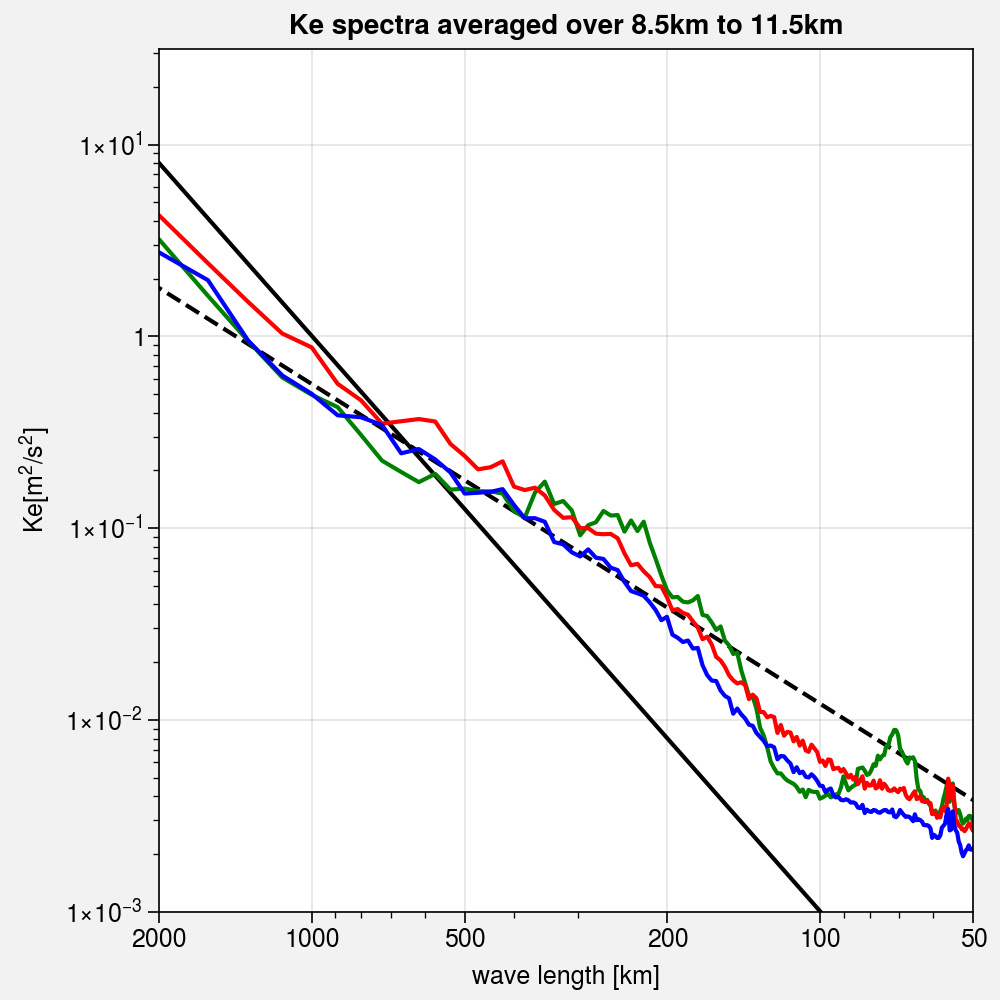

In [43]:
fig, axs = pplt.subplots(ncols = 1,nrows = 1,figsize=(5, 5))
# plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展

# 原始的DCT系数
# axs.plot(xf[:N//2], np.sqrt(variance_smooth['vr']))
xf = np.arange(1,nlon)
xaxis = xf[:N//2]
wavelen_1d = 2 * 10 / alpha_1d[:N//2]
# xaxis = N * alpha_1d[:N//2]
xaxis = wavelen_1d[:N//2]

# trunck_era5i = np.abs(wavelen_1d - 100).argmin()
# trunck_model = np.abs(wavelen_1d - 50).argmin()

trunck_era5i = np.abs(wavelen_1d - 10).argmin()
trunck_model = np.abs(wavelen_1d - 10).argmin()

# add reference line 
yref_synop = (1./xaxis) ** (-3.) * 10 ** (-9)
yref_meso  = (1./xaxis) ** (-5./3) * 10 ** (-5.25)
axs.plot(xaxis[1:], yref_synop[1:],color='k')
axs.plot(xaxis[1:], yref_meso[1:],color='k',linestyle = '--')

axs.set_xlabel('wave length [km]')
axs.set_ylabel(r'$Ke [m^2/s^2]$')
# axs.set_aspect(0.3, 'box')

def ktolen(x):
    return 20. * N /x
def lentok(x):
    return x / 20. / N
    
axs.plot(xaxis[3:trunck_era5i], np.sqrt(variance_1d_filter['era5i'][3:trunck_era5i]), label='era5i', color = 'g')
axs.plot(xaxis[3:trunck_model], np.sqrt(variance_1d_filter['vr'][3:trunck_model]), label='vr', color='r')
axs.plot(xaxis[3:trunck_model], np.sqrt(variance_1d_filter['rcm'][3:trunck_model]), label='rcm', color = 'b')
# axs.legend()
axs[0].format(
yscale = 'log',
xscale = 'log',
yformatter='sci',
ylocator = (1e-3,1e-2,1e-1,1e0,1e1,1e2),
ylim = (10**(-3),10**(1.5)),
xlim = (2000, 50),
xlocator = (2000,1000,500,200,100,50),
suptitle = 'Ke spectra averaged over 8.5km to 11.5km',
)

# plt.savefig('./output_pic/ke_variance_newproj_trunck_' + case_number + '.png', dpi=300, facecolor= "white")
# print('savfig to :' + './output_pic/ke_variance_newproj_trunck_' + case_number + '.png')

### 尝试，从方差谱计算出功率谱

In [22]:
# variance_1d_filter['vr'].shape
# wavelen_1d.shape

(200,)

In [36]:
powerspec = {}
# powerspec['vr'] = variance_1d_filter['vr'] * 1e4 * 400  / np.pi
# powerspec['rcm'] = variance_1d_filter['rcm'] * 1e4 * 400  / np.pi
# powerspec['era5i'] = variance_1d_filter['era5i'] * 1e4 * 400  / np.pi

# powerspec['vr'] = variance_1d_filter['vr'] * wavelen_1d  / np.pi
# powerspec['rcm'] = variance_1d_filter['rcm'] * wavelen_1d  / np.pi
# powerspec['era5i'] = variance_1d_filter['era5i'] * wavelen_1d  / np.pi

# 拟合曲线
d1 = 9.1 * 1e-4
d2 = 3.0 * 1e-10
ek_wavenumber = np.linspace(0,1e-3,10000)
ek = d1 * ek_wavenumber ** (-5/3) + d2 * ek_wavenumber ** (-3) 

<ipython-input-36-7de7c467789c>:14: RuntimeWarning: divide by zero encountered in power
  ek = d1 * ek_wavenumber ** (-5/3) + d2 * ek_wavenumber ** (-3)


<ipython-input-27-38f4f40958f6>:8: RuntimeWarning: divide by zero encountered in true_divide
  wavelen_1d = 2 * 1e4 / alpha_1d[:N//2]
<ipython-input-27-38f4f40958f6>:19: RuntimeWarning: divide by zero encountered in power
  yref_synop = (1./xaxis) ** (-3.) * 10 ** (-6)
<ipython-input-27-38f4f40958f6>:20: RuntimeWarning: divide by zero encountered in power
  yref_meso  = (1./xaxis) ** (-5./3) * 10 ** (-2)


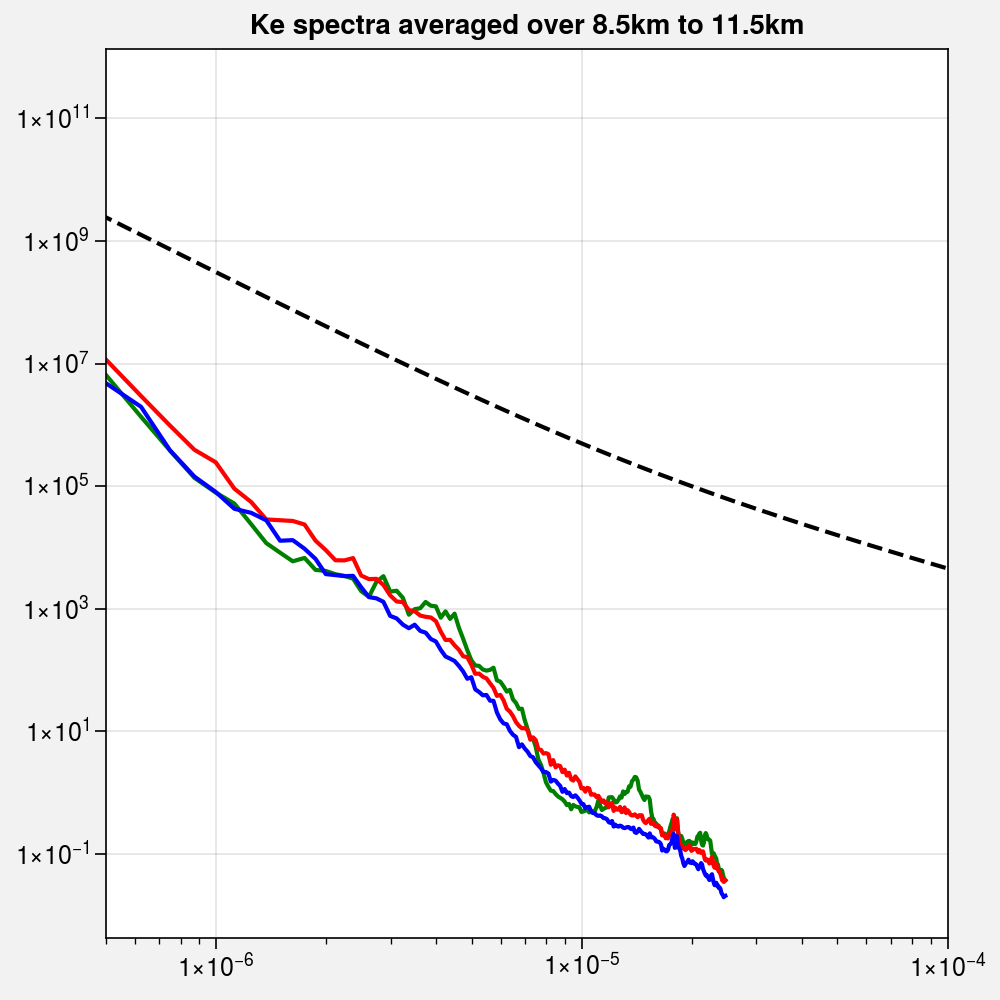

In [27]:
fig, axs = pplt.subplots(ncols = 1,nrows = 1,figsize=(5, 5))
# plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展

# 原始的DCT系数
# axs.plot(xf[:N//2], np.sqrt(variance_smooth['vr']))
xf = np.arange(1,nlon)
xaxis = xf[:N//2]
wavelen_1d = 2 * 1e4 / alpha_1d[:N//2]
# xaxis = N * alpha_1d[:N//2]
xaxis = wavelen_1d[:N//2]

# trunck_era5i = np.abs(wavelen_1d - 100).argmin()
# trunck_model = np.abs(wavelen_1d - 50).argmin()

trunck_era5i = np.abs(wavelen_1d - 10).argmin()
trunck_model = np.abs(wavelen_1d - 10).argmin()

# add reference line 
yref_synop = (1./xaxis) ** (-3.) * 10 ** (-6)
yref_meso  = (1./xaxis) ** (-5./3) * 10 ** (-2)
# axs.plot(xaxis[1:], yref_synop[1:],color='k')
# axs.plot(xaxis[1:], yref_meso[1:],color='k',linestyle = '--')

# 参考线的绘制
axs.plot(ek_wavenumber, ek,color='k',linestyle = '--')

# axs.set_xlabel('wave length [km]')
# axs.set_ylabel(r'$Ke [m^2/s^2]$')
# axs.set_aspect(0.3, 'box')

# axs_second_axis = axs[0]
def ktolen(x):
    return 20. * N /x
def lentok(x):
    return x / 20. / N
    
axs.plot(1./wavelen_1d[3:trunck_era5i], powerspec['era5i'][3:trunck_era5i], label='era5i', color = 'g')
axs.plot(1./wavelen_1d[3:trunck_model], powerspec['vr'][3:trunck_model], label='vr', color='r')
axs.plot(1./wavelen_1d[3:trunck_model], powerspec['rcm'][3:trunck_model], label='rcm', color = 'b')
# axs.legend()
axs[0].format(
yscale = 'log',
xscale = 'log',
yformatter='sci',
xformatter='sci',
# ylocator = (1e-3,1e-2,1e-1,1e0,1e1,1e2),
# ylim = (10**(0),10**(8)),
xlim = (1/2000/1e3, 1e-4),
# xlocator = (2000,1000,500,200,100,50),
suptitle = 'Ke spectra averaged over 8.5km to 11.5km',
)

# plt.savefig('./output_pic/ke_variance_newproj_trunck_' + case_number + '.png', dpi=300, facecolor= "white")
# print('savfig to :' + './output_pic/ke_variance_newproj_trunck_' + case_number + '.png')